s es: 0010
s1 es: 1101


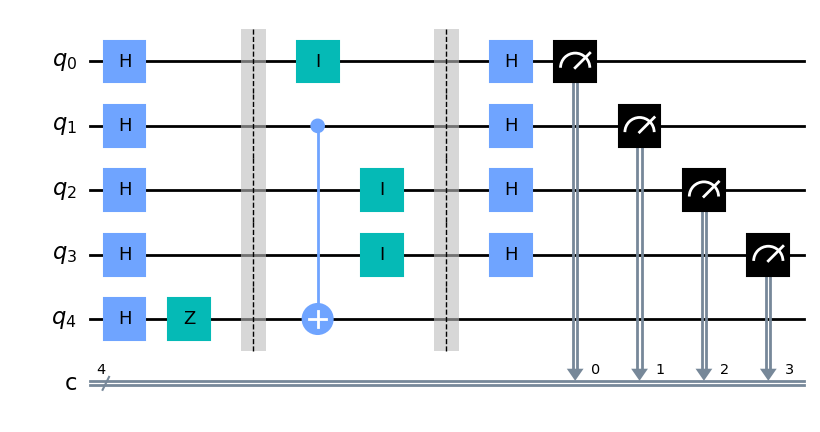

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

# Aquí se realizarón las primeras pruebas sobre el algoritmo de Bernstein-Vazirani, en adelante BV, así como la 
# construcción de los primeros oráculos. Está preparado para generar una cadena aleatoria, y a la vez genera su 
# complementario binario. Esto fueron los primeros test de la Regla I de BV, que luego se generalizarían en el 
# repositorio común.

n = 4
s = ''
s1 = ''

for i in range(0,n):
    k=random.randint(0,1)
    s+=str(k)
    if k==0:
        s1+='1'
    else:
        s1+='0'
print("s es:", s)
print("s1 es:", s1)


bv_circuit = QuantumCircuit(n+1, n)

bv_circuit.h(n)
bv_circuit.z(n)

for i in range(n):
    bv_circuit.h(i)

bv_circuit.barrier()

s = s[::-1] # Inversión del orden debido a los problemas de la base en Qiskit

# El propio qiskit reconoce en su página esta inversión
# https://learn.qiskit.org/course/ch-algorithms/bernstein-vazirani-algorithm

for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
bv_circuit.barrier()

for i in range(n):
    bv_circuit.h(i)

for i in range(n):
    bv_circuit.measure(i, i)
    
bv_circuit.draw(output='mpl')

#aer_sim = Aer.get_backend('aer_simulator')
#shots = 1024
#qobj = assemble(bv_circuit)
#results = aer_sim.run(qobj).result()
#answer = results.get_counts()

#plot_histogram(answer)

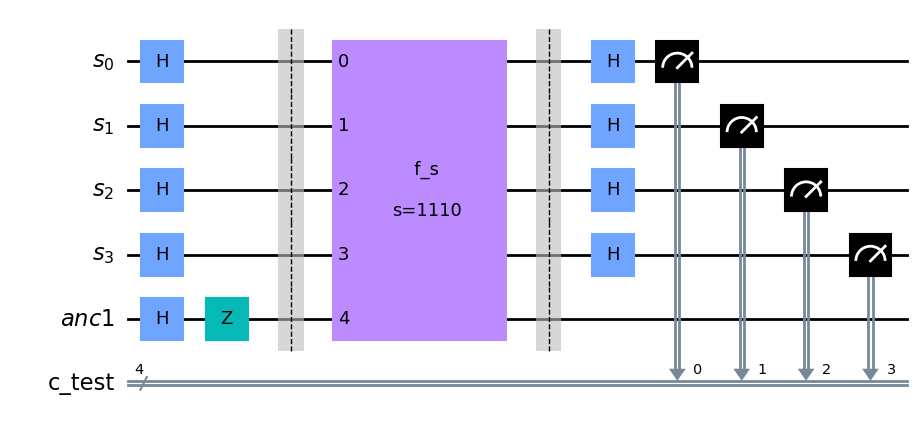

In [4]:
# Una vez ya realizadas las primeras pruebas y como funciona todo, se procede a la creación de funciones que engloban
# todo lo usado anteriormente, eso sí, ahora ya diferenciaremos los qubits dandoles nombre, mejorando así la 
# comprensión del circuito. 

def bv_fgenerator(n,s): # Genera el oráculo para una cadena s.
    qc=QuantumCircuit(n+1)
    s = s[::-1]
    for q in range(n):
        if s[q] == '0':
            qc.i(q)
        else:
            qc.cx(q, n)
    return qc

def circuito(s): # Generamos el circuito que representa el algoritmo de BV, encapsulando el oráculo como una puerta.
    n=len(s)
    f=bv_fgenerator(n,s)
    f_s= f.to_gate(label='   f_s   \n\n'+'s='+s) # Transformamos un circuito en una puerta.
    
    qs=QuantumRegister(n, 's')
    anc1=QuantumRegister(1, 'anc1')
    c_test=ClassicalRegister(n, 'c_test')
    qc = QuantumCircuit(qs, anc1, c_test)

    for i in range(n+1):
        qc.h(i)
    qc.z(n)

    qc.barrier()
    qc.append(f_s, range(n+1)) # Al igual que en el resto de puertas, tenemos que determinar los qubits de actuación.
    qc.barrier()
    
    for i in range(n):
        qc.h(i)
    
    for i in range(n):
        qc.measure(i, i)
    
    return qc

s='1110'
q=circuito(s)
#q.qasm() # Nos permitiría ver la programación en Qasm generada para la ejecución
q.draw(output='mpl') # Nos permite ver el circuito en distintos formatos
# Para que el circuito se muestre, no debe haber ninguna ejecución después, si eso, se podría utilizar un print.

In [2]:
# Guardamos nuestra cuenta de IBM Quantum, para poder hacer simulaciones 

IBMQ.save_account('######')

configrc.store_credentials:WARNING:2022-11-18 07:52:58,478: Credentials already present. Set overwrite=True to overwrite.


In [8]:
# Cargamos nuestra cuenta y vamos a realizar ejecuciones en sistemas cuánticos reales.
# La función least_busy buscará el sistema con menos cola, no nos tenemos que olvidar de actualizar los filtros.
# Esto nos ayudará a adecuar el sistema elegido con las características de nuestro circuito.
# Es decir, podríamos llegar elegir un sistema no apto para nosotros, por ejemplo si no tuviera los suficientes qubits

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


Job Status: job has successfully run


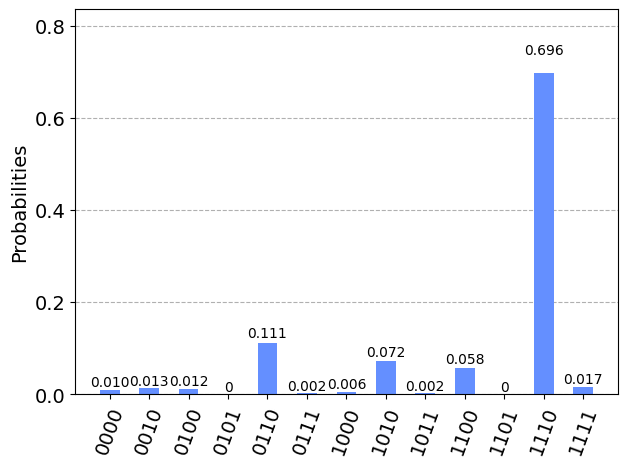

In [4]:
# Ejecución realizada con ibmq_quito, realizada el 18 de noviembre de 2022.

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Job Status: job has successfully run


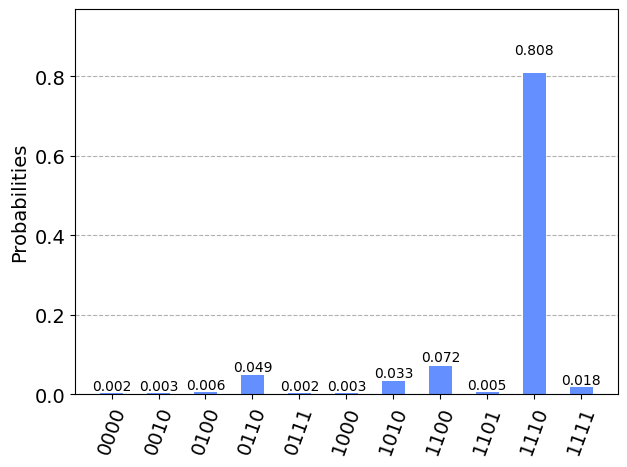

In [9]:
# Ejecución realizada con ibmq_lima, realizada el 27 de junio de 2023.
# El objetivo de esta ejecución era mostrar los circuitos que usa IBM en sus sistemas, ya que una vez pasados unos
# meses, estos circuitos ya no están disponibles en la página de IBM
# Además, también nos permite comparar resultados, ya que el circuito ejecutado es idéntico.

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
# El circuito que uso IBM en ibmq_lima, se encuentra en la memoria del TFG. La figura 2.5 en la página 21.
# Otra de las posibilidades que se dan y que es como se introduce esa figura, es la conversión de Qiskit a Qasm,
# debido a la longitud que presenta el código cuando revisamos el trabajo en IBM, en vez de presentarlo en la memoria
# he decidido presentarlo aquí.

# Este es el código qasm, del circuito anterior que hemos estado utilizando durante toda esta práctica:

OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];

creg c[4];


rz(1.5707963267948966) q[0];
sx q[0];
rz(1.5707963267948966) q[0];
rz(1.5707963267948966) q[1];
sx q[1];
rz(-1.5707963267948966) q[1];
rz(1.5707963267948966) q[2];
sx q[2];
rz(1.5707963267948966) q[2];
rz(1.5707963267948966) q[3];
sx q[3];
rz(1.5707963267948966) q[3];
rz(1.5707963267948966) q[4];
sx q[4];
rz(1.5707963267948966) q[4];
barrier q[4], q[3], q[0], q[2], q[1];
cx q[3], q[1];
cx q[0], q[1];
cx q[2], q[1];
barrier q[4], q[3], q[0], q[2], q[1];
rz(1.5707963267948966) q[0];
sx q[0];
rz(1.5707963267948966) q[0];
rz(1.5707963267948966) q[2];
sx q[2];
rz(1.5707963267948966) q[2];
rz(1.5707963267948966) q[3];
sx q[3];
rz(1.5707963267948966) q[3];
rz(1.5707963267948966) q[4];
sx q[4];
rz(1.5707963267948966) q[4];
measure q[4] -> c[0];
measure q[3] -> c[1];
measure q[0] -> c[2];
measure q[2] -> c[3];